In [36]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data187717


In [37]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [38]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: 无法创建目录"/home/aistudio/external-libraries": 文件已存在
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/9c/d8/909c4089dbe4ade9f9705f143c9f13f065049a9d5e7d34c828aefdd0a97c/beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/16/e3/4ad79882b92617e3a4a0df1960d6bce08edfb637737ac5c3f3ba29022e25/soupsieve-2.3.2.post1-py3-none-any.whl (37 kB)

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [26]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [39]:
#数据读取
# 导入深度学习框架
import paddle
import paddle.nn.functional as F
import paddle.nn.initializer as I
import re
import os
import jieba
import random
import tarfile
import requests
import numpy as np
from collections import Counter
from collections import defaultdict

def load_dataset(path):
    # 生成加载数据的地址
    train_path = os.path.join(path, "train.txt")
    test_path = os.path.join(path, "dev.txt")
    dict_path = os.path.join(path, "dict_word.txt")  # 词典表
    label_path = os.path.join(path, "label_dict.txt") # 1和-1对应积极消极

    # 加载词典
    with open(dict_path, "r", encoding="utf-8") as f:
        words = [word.strip() for word in f.readlines()]
        word_dict = dict(zip(words, range(len(words))))

    # 加载标签词典
    with open(label_path, "r", encoding="utf-8") as f:
        lines = [line.strip().split() for line in f.readlines()]
        lines = [(line[0], int(line[1])) for line in lines]
        label_dict = dict(lines)

    def load_data(data_path):
        data_set = []
        with open(data_path, "r", encoding="utf-8") as f:
            for line in f.readlines():
                label, text = line.strip().split("\t", maxsplit=1)
                data_set.append((text, label))
        return data_set
    train_set = load_data(train_path)
    test_set = load_data(test_path)

    return train_set, test_set, word_dict, label_dict

In [28]:
# 将文本序列进行分词，然后词转换为字典ID
def convert_corpus_to_id(data_set, word_dict, label_dict):
    tmp_data_set = []
    for text, label in data_set:
        text = [word_dict.get(word, word_dict["[oov]"]) for word in jieba.cut(text)]
        tmp_data_set.append((text, label_dict[label]))

    return tmp_data_set

In [40]:
# 组装minibatch
# 构造训练数据，每次传入模型一个batch，一个batch里面有batch_size条样本
def build_batch(data_set,  batch_size, max_seq_len, shuffle=True, drop_last=True, pad_id=1):
    batch_text = []
    batch_label = []

    if shuffle:
        random.shuffle(data_set)

    for text, label in data_set:
        # 截断数据
        text = text[:max_seq_len]
        # 填充数据到固定长度
        if len(text) < max_seq_len:
            text.extend([pad_id]*(max_seq_len-len(text)))

        assert len(text) == max_seq_len
        batch_text.append(text)
        batch_label.append([label])

        if len(batch_text) == batch_size:
            yield np.array(batch_text).astype("int64"), np.array(batch_label).astype("int64")
            batch_text.clear()
            batch_label.clear()

    # 处理是否删掉最后一个不足batch_size 的batch数据
    if (not drop_last) and len(batch_label) > 0:
        yield np.array(batch_text).astype("int64"), np.array(batch_label).astype("int64")

* 对于给定的一个新闻文本，经过分词后，便可获得一串单词序列（$x_1$……$x_T$），每个单词均可映射为对应的词向量（$e_1$……$e_T$），将这些词向量，按照时间步骤依次传入Bi-LSTM中；
* Bi-LSTM接收到这些向量后，会在每个单词的位置输出一个前向向量 $\stackrel{\rightarrow}{h_i}$ 和后向向量 $\stackrel{\leftarrow}{h_i}$，然后将每个时间步骤对应的两个向量进行拼接，作为最终的输出向量 $h_i$。由于$h_i$融合了上下文信息，暂且称之为上下文向量； 
* 在这些上下文向量中应用Attention机制，获得整个文本序列的语义向量；   
* 将语义向量传入全连接层和softmax，就可以得到这个新闻标题的文本类别。


In [41]:
# attention 
class AttentionLayer(paddle.nn.Layer):
    def __init__(self, hidden_size, init_scale=0.1):
        super(AttentionLayer, self).__init__()
        self.w = paddle.create_parameter(shape=[hidden_size, hidden_size], dtype="float32")
        self.v = paddle.create_parameter(shape=[1, hidden_size], dtype="float32")

    def forward(self, inputs):
        # inputs:  [batch_size, seq_len, hidden_size]
        last_layers_hiddens = inputs
        # transposed inputs: [batch_size, hidden_size, seq_len]
        inputs = paddle.transpose(inputs, perm=[0, 2, 1])
        # inputs: [batch_size, hidden_size, seq_len]
        inputs = paddle.tanh(paddle.matmul(self.w, inputs))
        # attn_weights: [batch_size, 1, seq_len]
        attn_weights = paddle.matmul(self.v, inputs)
        # softmax数值归一化
        attn_weights = F.softmax(attn_weights, axis=-1)
        # 通过attention后的向量值, attn_vectors: [batch_size, 1, hidden_size]
        attn_vectors = paddle.matmul(attn_weights, last_layers_hiddens)
        # attn_vectors: [batch_size, hidden_size]
        attn_vectors = paddle.squeeze(attn_vectors, axis=1)

        return attn_vectors

In [42]:
# 分类器构建 

class Classifier(paddle.nn.Layer):
    def __init__(self, hidden_size, embedding_size, vocab_size, n_classes=14, n_layers=1, direction="bidirectional",
                 dropout_rate=0., init_scale=0.05):
        super(Classifier, self).__init__()
        # 表示LSTM单元的隐藏神经元数量，它也将用来表示hidden和cell向量状态的维度
        self.hidden_size = hidden_size
        # 表示词向量的维度
        self.embedding_size = embedding_size
        # 表示神经元的dropout概率
        self.dropout_rate = dropout_rate
        # 表示词典的的单词数量
        self.vocab_size = vocab_size
        # 表示文本分类的类别数量
        self.n_classes = n_classes
        # 表示LSTM的层数
        self.n_layers = n_layers
        # 用来设置参数初始化范围
        self.init_scale = init_scale

        # 定义embedding层
        self.embedding = paddle.nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_size,
                                             weight_attr=paddle.ParamAttr(
                                                 initializer=I.Uniform(low=-self.init_scale, high=self.init_scale)))
        
        # 定义LSTM，它将用来编码网络
        self.lstm = paddle.nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size,
                                   num_layers=self.n_layers, direction=direction,
                                   dropout=self.dropout_rate)


        # 对词向量进行dropout
        self.dropout_emb = paddle.nn.Dropout(p=self.dropout_rate, mode="upscale_in_train")

        # 定义Attention层
        self.attention = AttentionLayer(hidden_size=hidden_size*2 if direction == "bidirectional" else hidden_size)

        # 定义分类层，用于将语义向量映射到相应的类别
        self.cls_fc = paddle.nn.Linear(in_features=self.hidden_size*2 if direction == "bidirectional" else hidden_size,
                                       out_features=self.n_classes)

    def forward(self, inputs):
        # 获取训练的batch_size
        batch_size = inputs.shape[0]
        # 获取词向量并且进行dropout
        embedded_input = self.embedding(inputs)
        if self.dropout_rate > 0.:
            embedded_input = self.dropout_emb(embedded_input)

        # 使用LSTM进行语义编码
        last_layers_hiddens, (last_step_hiddens, last_step_cells) = self.lstm(embedded_input)

        # 进行Attention, attn_weights: [batch_size, seq_len]
        attn_vectors = self.attention(last_layers_hiddens)

        # 通过attention后的向量值, attn_vector: [batch_size, 1, hidden_size]
        # attn_vector = paddle.matmul(attn_weights, last_layers_hiddens)
        # attn_vector: [batch_size, hidden_size]
        # attn_vector = paddle.squeeze(attn_vector, axis=1)

        # 将其通过分类线性层，获得初步的类别数值
        logits = self.cls_fc(attn_vectors)

        return logits


## 参数配置

In [47]:
# 加载数据集
root_path = "./data/data187717"
train_set, test_set, word_dict, label_dict = load_dataset(root_path)
train_set = convert_corpus_to_id(train_set, word_dict, label_dict)
test_set = convert_corpus_to_id(test_set, word_dict, label_dict)
id2label = dict([(item[1], item[0]) for item in label_dict.items()])

# 参数设置
n_epochs = 15
vocab_size = len(word_dict.keys())
print(vocab_size)
batch_size = 128
hidden_size = 128
embedding_size = 128
n_classes = 2
max_seq_len = 32
n_layers = 1
dropout_rate = 0.2
learning_rate = 0.0001
direction = "bidirectional"

# 检测是否可以使用GPU，如果可以优先使用GPU
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')

# 实例化模型
classifier = Classifier(hidden_size, embedding_size, vocab_size, n_classes=n_classes, n_layers=n_layers,
                        direction=direction, dropout_rate=dropout_rate)

# 指定优化器
optimizer = paddle.optimizer.Adam(learning_rate=learning_rate, beta1=0.9, beta2=0.99,
                                  parameters=classifier.parameters())

8852


In [48]:
# 模型训练与评估
from utils.metric import Metric


# 模型评估代码
def evaluate(model):
    model.eval()
    metric = Metric(id2label)

    for batch_texts, batch_labels in build_batch(test_set, batch_size, max_seq_len, shuffle=False, pad_id=word_dict["[pad]"]):
        # 将数据转换为Tensor类型
        batch_texts = paddle.to_tensor(batch_texts)
        batch_labels = paddle.to_tensor(batch_labels)

        # 执行模型的前向计算
        logits = model(batch_texts)

        # 使用softmax进行归一化
        probs = F.softmax(logits)

        probs = paddle.argmax(probs, axis=1).numpy()
        batch_labels = batch_labels.squeeze().numpy()
        
        metric.update(real_labels=batch_labels, pred_labels=probs)
    
    result = metric.get_result()
    metric.format_print(result)


# 模型训练代码
# 记录训练过程中的中间变量
loss_records = []
def train(model):
    

    global_step = 0
    for epoch in range(n_epochs):
        model.train()
        for step, (batch_texts, batch_labels) in enumerate(build_batch(train_set, batch_size, max_seq_len, shuffle=True, pad_id=word_dict["[pad]"])):
            # 将数据转换为Tensor类型
            batch_texts = paddle.to_tensor(batch_texts)
            batch_labels = paddle.to_tensor(batch_labels)

            # 执行模型的前向计算
            logits = model(batch_texts)

            # 计算损失
            losses = F.cross_entropy(input=logits, label=batch_labels, soft_label=False)
            loss = paddle.mean(losses)

            loss.backward()
            optimizer.step()
            optimizer.clear_gradients()

            if step % 200 == 0:
                loss_records.append((global_step, loss.numpy()[0]))
                print(f"Epoch: {epoch+1}/{n_epochs} - Step: {step} - Loss: {loss.numpy()[0]}")

            global_step += 1
        
        # 模型评估
        evaluate(model)

# 训练模型
train(classifier)

Epoch: 1/15 - Step: 0 - Loss: 0.6925662755966187


Total: Precision: 0.4229 - Recall: 0.4229 - F1: 0.4229
Entity: 积极 - Precision: 0.4229 - Recall: 1.0 - F1: 0.5944
Entity: 消极 - Precision: 0 - Recall: 0.0 - F1: 0.0


Epoch: 2/15 - Step: 0 - Loss: 0.6858921051025391


Total: Precision: 0.4229 - Recall: 0.4229 - F1: 0.4229
Entity: 积极 - Precision: 0.4229 - Recall: 1.0 - F1: 0.5944
Entity: 消极 - Precision: 0 - Recall: 0.0 - F1: 0.0


Epoch: 3/15 - Step: 0 - Loss: 0.686686098575592


Total: Precision: 0.6661 - Recall: 0.6661 - F1: 0.6661
Entity: 积极 - Precision: 0.5718 - Recall: 0.8378 - F1: 0.6797
Entity: 消极 - Precision: 0.8196 - Recall: 0.5403 - F1: 0.6513


Epoch: 4/15 - Step: 0 - Loss: 0.5887160301208496


Total: Precision: 0.6658 - Recall: 0.6658 - F1: 0.6658
Entity: 积极 - Precision: 0.5751 - Recall: 0.8024 - F1: 0.67
Entity: 消极 - Precision: 0.7962 - Recall: 0.5656 - F1: 0.6614


Epoch: 5/15 - Step: 0 - Loss: 0.493984580039978


Total: Precision: 0.6675 - Recall: 0.6675 - F1: 0.6675
Entity

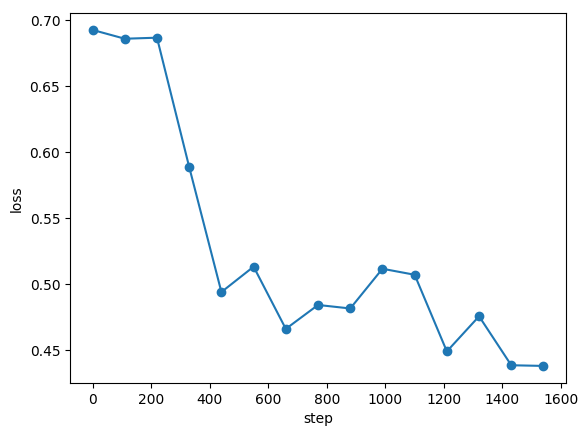

In [49]:
# 训练可视化
import matplotlib.pyplot as plt

# 开始画图，横轴是训练step，纵轴是损失
loss_records =  np.array(loss_records)
steps, losses = loss_records[:, 0], loss_records[:, 1]

plt.plot(steps, losses, "-o")
plt.xlabel("step")
plt.ylabel("loss")
plt.savefig("./loss.png")
plt.show()

In [50]:
# 保存模型
# 模型保存的名称
model_name = "classifier"
# 保存模型
paddle.save(classifier.state_dict(), "{}.pdparams".format(model_name))
paddle.save(optimizer.state_dict(), "{}.optparams".format(model_name))

## 模型预测

In [53]:
# 模型预测代码
def infer(model, text):
    model.eval()
    # 数据处理
    tokens = [word_dict.get(word, word_dict["[oov]"]) for word in jieba.cut(text)]

    # 构造输入模型的数据
    tokens = paddle.to_tensor(tokens, dtype="int64").unsqueeze(0)


    # 计算发射分数
    logits = model(tokens)
    probs = F.softmax(logits)

    # 解析出分数最大的标签
    max_label_id = paddle.argmax(logits, axis=1).numpy()[0]
    pred_label = id2label[max_label_id]

    print("Label: ", pred_label)

title = "速度好"
infer(classifier, title)


Label:  积极
